In [1]:
import numpy as np
from numpy import sqrt, pi
import math
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import cadquery as cq
from cadquery import exporters
from jupyter_cadquery.cadquery import (PartGroup, Part, Edges, Faces, Vertices, show)
from jupyter_cadquery import set_defaults, set_sidecar
set_defaults(theme="dark")
set_sidecar("CadQuery", init=True)

from tqdm import tqdm
import winsound
from time import perf_counter

import os
from pathlib import Path
cwd=os.getcwd()
home = str(Path(os.path.abspath(cwd)).parents[1])

Overwriting auto display for cadquery Workplane and Shape


In [2]:
# FUNCTIONS

In [3]:
def hexGen(xVect,yVect):
    for i in range(len(yVect)):
        if i==0:
            yNew=np.ones(len(xVect))*yVect[i]
            xNew=xVect
        else:
            yNew=np.concatenate((yNew, np.ones(len(xVect))*yVect[i]), axis=None)
            xNew=np.concatenate((xNew, xVect), axis=None)
    return xNew, yNew

In [4]:
def abcGen(L,T,a0,X,Y,Z,A,):
    sD=cq.Workplane('XY').transformed(offset=cq.Vector(0, 0, Z[0])).rect(L,T,centered=True,forConstruction=False).extrude(a0)

    hexes=[]

    for i in tqdm(range(X.size)):
        hexPrism=cq.Workplane('XY').transformed(offset=cq.Vector(X[i], Y[i], Z[i]),rotate=cq.Vector(0, 0, 90)).polygon(6,A[i]*2,forConstruction=False).extrude(a0)
        hexes.append(hexPrism)

    for i in tqdm(range(len(hexes))):
        sD=sD.cut(hexes[i],clean=True)

    return sD

In [5]:
def densify(R,VF,d):
    volFrac=np.ones(len(R))
    for i in range(len(R)):
        if R[i]<=(d/2):
            volFrac[i]=1
        else:
            volFrac[i]=np.exp(-0.8*(R[i]-d/2)+np.log(1-VF))+VF
    return volFrac

In [6]:
def calcSideLen(volFrac,d):
    A=np.zeros(len(volFrac))
    for i in range(len(volFrac)):
        A[i]=(volFrac[i]*sqrt((d*d*(1-volFrac[i]))/(volFrac[i]*volFrac[i]))+d*(1-volFrac[i]))/(sqrt(3)*volFrac[i])
    return A

In [7]:
def calcDist(X,Y):
    R=np.zeros(len(X))
    for i in range(len(R)):
        R[i]=sqrt(X[i]*X[i]+Y[i]*Y[i])
    return R

In [8]:
def remPts(X,Y,Z,R,vF,A,d):
    rem_ind=[]
    for i in range(len(R)):
        if (R[i]-A[i])<(d/2) or A[i]<=0.05:
            rem_ind.append(i)
    rem_ind.reverse()
    for i in range(len(rem_ind)):
        X=np.delete(X,rem_ind[i])
        Y=np.delete(Y,rem_ind[i])
        Z=np.delete(Z,rem_ind[i])
        R=np.delete(R,rem_ind[i])
        vF=np.delete(vF,rem_ind[i])
        A=np.delete(A,rem_ind[i])
    return X, Y, Z, R, vF, A

In [9]:
# DATA

VF=0.14      #Volume Fraction
a0=0.625     #[mm] Average Cell Size / 2
L=20         #[mm] Length (x) of Sample
T=20         #[mm] Width (y) of Sample
U=20         #[mm] Height (z) of Sample
holeDiam=2.7 #[mm] Diameter of Drilled Hole
dImpl=3.8    #[mm] Greatest Outer Diameter of the Implant

d=sqrt(3)*(sqrt((a0*a0)/(1-VF))-a0) #initial wall thickness
D=sqrt(3)*a0+d #Distance between Hex Centres on the x axis
H=sqrt(3)*D/2 #Distance between Hex Centres on the y axis

Nxa=math.ceil(L/D+1)
if Nxa%2 != 1: #if not odd
    Nxb=Nxa+2 #then with +2 it is good for b-row
    Nxa=Nxa+1 #and has to be incremented for a-row
else: #if odd
    Nxb=Nxa+1 #then a is good, b must be incremented
    
Ny=math.ceil(T/H+1)
if Ny%2 != 1: #if not odd
    Ny=Ny+1 #then increment it
if ((Ny-1)/2)%2 != 1: #if not odd
    Nya=int((Ny+1)/2)
    Nyb=int(Nya+1)
else:
    Nyb=int((Ny+1)/2)
    Nya=int(Nyb+1)
Ny=Nya+Nyb
print("d = ", d,"\nD = ", D, "\nH = ", H, "\nNx:\n\tNxa = ", Nxa, "\n\tNxb = ", Nxb, "\nNy = ", Ny,"\n\tNya = ", Nya, "\n\tNyb = ", Nyb)

d =  0.08479225720324611 
D =  1.1673240119337942 
H =  1.010932248782235 
Nx:
	Nxa =  19 
	Nxb =  20 
Ny =  23 
	Nya =  11 
	Nyb =  12


In [10]:
# LAYER 'A'

aX=np.linspace(-((Nxa-1)*D)/2, ((Nxa-1)*D)/2, num=Nxa)
bX=np.linspace(-((Nxa-1)*D)/2-(D/2), ((Nxa-1)*D)/2+(D/2), num=Nxb)

if Nya>Nyb:
    aY=np.linspace(-((Nya+Nyb-1)*H)/2, ((Nya+Nyb-1)*H)/2, num=Nya)
    bY=np.linspace(-((Nya+Nyb-1)*H)/2+H, ((Nya+Nyb-1)*H)/2-H, num=Nyb)
else:
    bY=np.linspace(-((Nya+Nyb-1)*H)/2, ((Nya+Nyb-1)*H)/2, num=Nyb)
    aY=np.linspace(-((Nya+Nyb-1)*H)/2+H, ((Nya+Nyb-1)*H)/2-H, num=Nya)

aX0=aX
aY0=aY
bX0=bX
bY0=bY
AaX, AaY = hexGen(aX0,aY0)
AbX, AbY = hexGen(bX0,bY0)

#%matplotlib widget
#plt.plot(AaX,AaY,'b.')
#plt.plot(AbX,AbY,'r.')
#plt.axis('equal')
#plt.show()

In [11]:
# LAYER 'B'

BaX=AaX
BaY=AaY-(a0+(d/sqrt(3)))
BbX=AbX
BbY=AbY-(a0+(d/sqrt(3)))

if Nya>Nyb: #'a' row is on the outside
    BbX=np.concatenate((BbX, bX0), axis=None)
    BbY=np.concatenate((BbY, np.ones(len(bX0))*(BaY[-1]+H)), axis=None)
        
else: #'b' row is on the outside
    BaX=np.concatenate((BaX, aX0), axis=None)
    BaY=np.concatenate((BaY, np.ones(len(aX0))*(BbY[-1]+H)), axis=None)

#%matplotlib widget
#plt.plot(AaX,AaY,'g.')
#plt.plot(AbX,AbY,'g.')
#plt.plot(BaX,BaY,'b.')
#plt.plot(BbX,BbY,'b.')
#plt.axis('equal')
#plt.show()

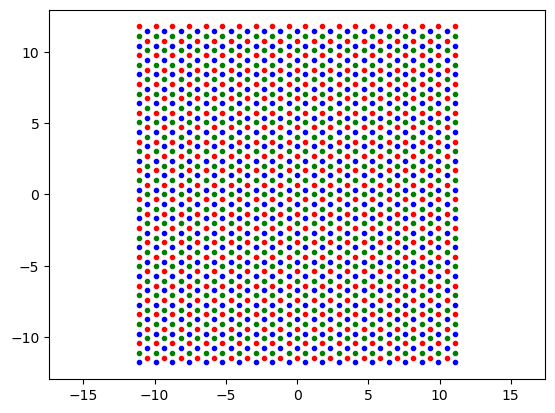

In [12]:
# LAYER 'C'

CaX=AaX
CaY=AaY+(a0+(d/sqrt(3)))
CbX=AbX
CbY=AbY+(a0+(d/sqrt(3)))

if Nya>Nyb: #'a' row is on the outside
    CbX=np.concatenate((CbX, bX0), axis=None)
    CbY=np.concatenate((CbY, np.ones(len(bX0))*(CaY[0]-H)), axis=None)
        
else: #'b' row is on the outside
    CaX=np.concatenate((CaX, aX0), axis=None)
    CaY=np.concatenate((CaY, np.ones(len(aX0))*(CbY[0]-H)), axis=None)

#%matplotlib widget
plt.plot(AaX,AaY,'g.')
plt.plot(AbX,AbY,'g.')
plt.plot(BaX,BaY,'b.')
plt.plot(BbX,BbY,'b.')
plt.plot(CaX,CaY,'r.')
plt.plot(CbX,CbY,'r.')
plt.axis('equal')
plt.show()

In [13]:
AX=np.concatenate((AaX, AbX), axis=None)
AY=np.concatenate((AaY, AbY), axis=None)
BX=np.concatenate((BaX, BbX), axis=None)
BY=np.concatenate((BaY, BbY), axis=None)
CX=np.concatenate((CaX, CbX), axis=None)
CY=np.concatenate((CaY, CbY), axis=None)

#%matplotlib widget
#plt.plot(AX,AY,'g.')
#plt.plot(BX,BY,'b.')
#plt.plot(CX,CY,'r.')
#plt.axis('equal')
#plt.show()

In [14]:
AZ=np.zeros((len(AX)))
BZ=np.ones((len(BX)))*a0
CZ=np.ones((len(BX)))*2*a0

X=np.concatenate((AX,BX,CX), axis=None)
Y=np.concatenate((AY,BY,CY), axis=None)
Z=np.concatenate((AZ,BZ,CZ), axis=None)

In [15]:
data = [
    {
        'type': 'scatter3d',
        'x': X,
        'y': Y,
        'z': Z,
        'mode': 'markers',
        'marker': dict(size=2,color="#19D3F3",line=dict(width=0.5,color='DarkSlateGrey')),
    },
]

layout = {
    'scene': {
        'aspectmode':'data',
        'camera': {
            'projection': {
                'type': 'orthographic',
            }
        }
        
    },
}

fw = go.FigureWidget(data=data, layout=layout)
fw
fw.write_html(home+"\\img\\python\\generateStructure_final_fig_01.html")

In [16]:
R=calcDist(X,Y)

In [17]:
zeroIndex=np.where(R==0)[0][0]
X=np.delete(X,zeroIndex,None)
Y=np.delete(Y,zeroIndex,None)
Z=np.delete(Z,zeroIndex,None)
R=np.delete(R,zeroIndex,None)

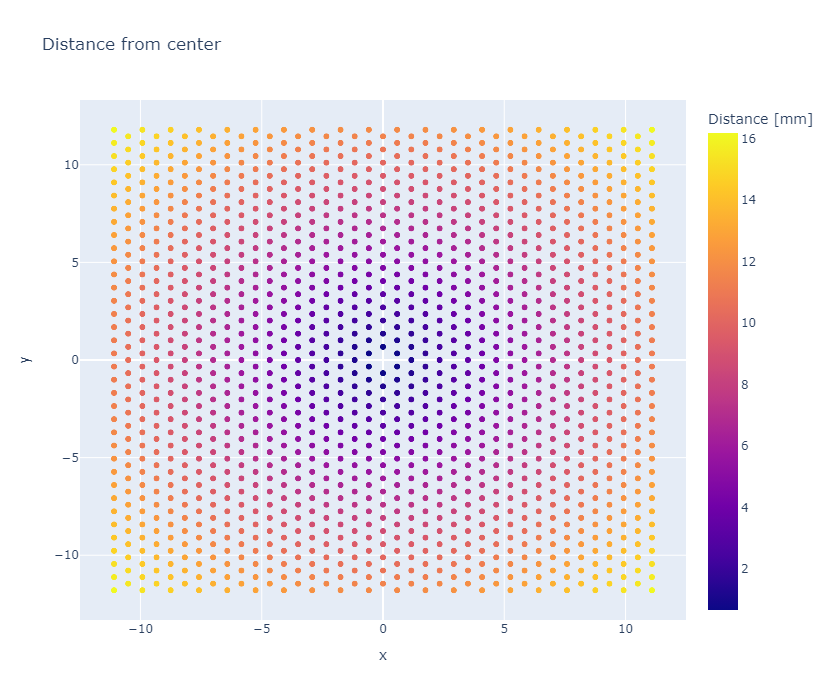

In [18]:
fig = px.scatter(x=X, y=Y, color=R, labels={"color":"Distance [mm]"},
                 title="Distance from center",width=700,height=700)
fig.show()
fig.write_html(home+"\\img\\python\\generateStructure_final_fig_02.html")

In [19]:
volFrac=densify(R,VF,dImpl)
A=calcSideLen(volFrac,d)

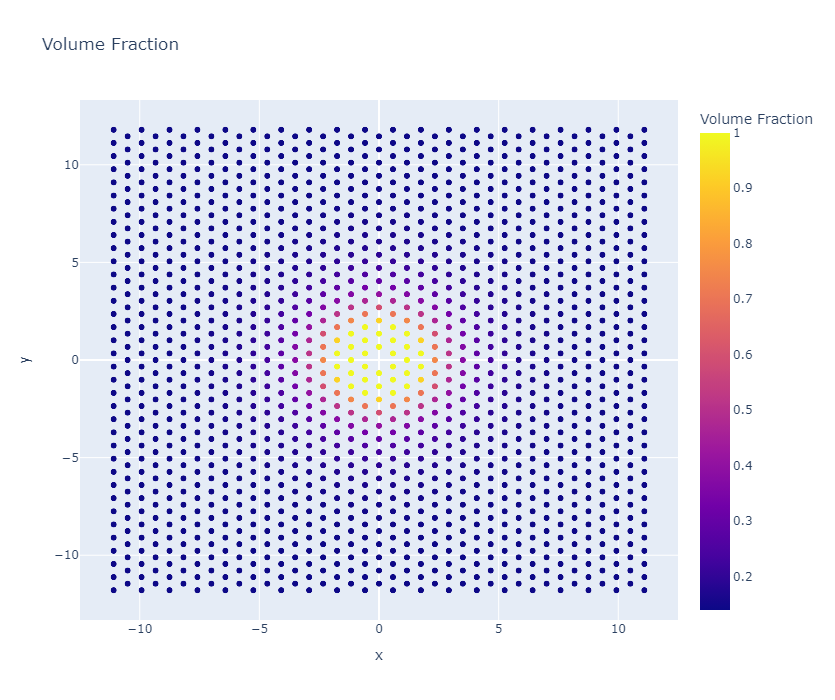

In [20]:
fig = px.scatter(x=X, y=Y, color=volFrac, labels={"color":"Volume Fraction"},
                 title="Volume Fraction",width=700,height=700,color_continuous_scale='Plasma')
fig.show()
fig.write_html(home+"\\img\\python\\generateStructure_final_fig_03.html")

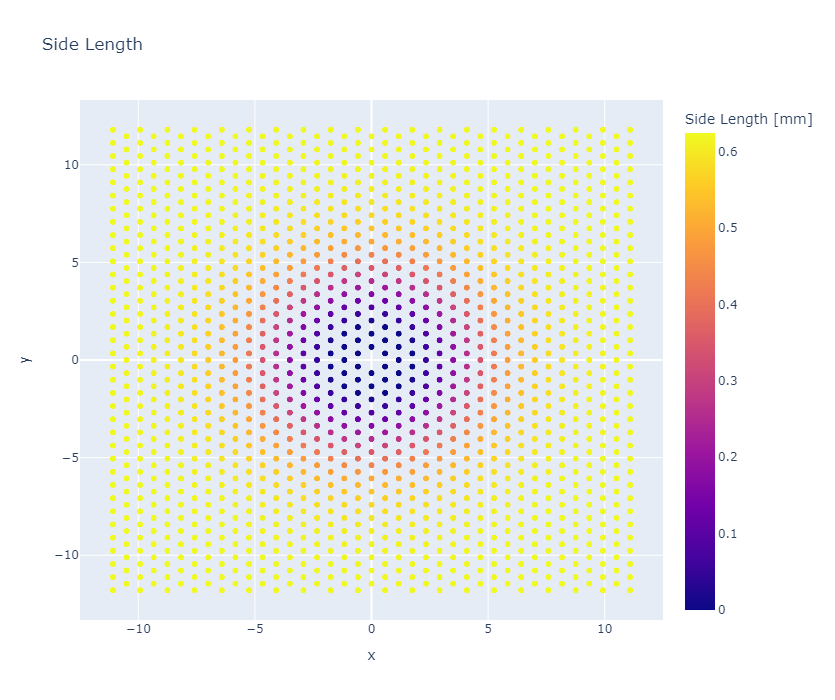

In [21]:
fig = px.scatter(x=X, y=Y, color=A, labels={"color":"Side Length [mm]"},
                 title="Side Length",width=700,height=700)
fig.show()
fig.write_html(home+"\\img\\python\\generateStructure_final_fig_04.html")

In [22]:
RA=calcDist(AX,AY)
RB=calcDist(BX,BY)
RC=calcDist(CX,CY)

zeroIndex=np.where(RA==0)[0][0]
AX=np.delete(AX,zeroIndex,None)
AY=np.delete(AY,zeroIndex,None)
AZ=np.delete(AZ,zeroIndex,None)
RA=np.delete(RA,zeroIndex,None)

volFracA=densify(RA,VF,dImpl)
volFracB=densify(RB,VF,dImpl)
volFracC=densify(RC,VF,dImpl)

AA=calcSideLen(volFracA,d)
AB=calcSideLen(volFracB,d)
AC=calcSideLen(volFracC,d)

AX, AY, AZ, RA, volFracA, AA = remPts(AX, AY, AZ, RA, volFracA, AA, dImpl)
BX, BY, BZ, RB, volFracB, AB = remPts(BX, BY, BZ, RB, volFracB, AB, dImpl)
CX, CY, CZ, RC, volFracC, AC = remPts(CX, CY, CZ, RC, volFracC, AC, dImpl)

X=np.concatenate((AX,BX,CX), axis=None)
Y=np.concatenate((AY,BY,CY), axis=None)
Z=np.concatenate((AZ,BZ,CZ), axis=None)
#%matplotlib widget
#plt.plot(X,Y,'b.')
#plt.axis('equal')
#plt.show()

In [23]:
sDA=abcGen(L,T,a0,AX,AY,AZ,AA)
show(sDA, grid=True)

100%|██████████| 430/430 [02:23<00:00,  2.99it/s]


Done, using side car 'Cadquery'


In [24]:
#tic = perf_counter()
#exporters.export(sDA, home+'\\out\\step\\BAM_A.step')
#tac = perf_counter()
#print("Elapsed time:", '%.5f' % (tac-tic) , "s")

In [25]:
sDB=abcGen(L,T,a0,BX,BY,BZ,AB)
show(sDB, grid=True)

100%|██████████| 456/456 [02:31<00:00,  3.02it/s]


Done, using side car 'Cadquery'


In [26]:
#tic = perf_counter()
#exporters.export(sDB, home+'\\out\\step\\BAM_B.step')
#tac = perf_counter()
#print("Elapsed time:", '%.5f' % (tac-tic) , "s")

In [27]:
sDC=abcGen(L,T,a0,CX,CY,CZ,AC)
show(sDC, grid=True)

100%|██████████| 456/456 [02:37<00:00,  2.90it/s]


Done, using side car 'Cadquery'


In [28]:
#tic = perf_counter()
#exporters.export(sDC, home+'\\out\\step\\BAM_C.step')
#tac = perf_counter()
#print("Elapsed time:", '%.5f' % (tac-tic) , "s")

In [29]:
tic = perf_counter()
sDABC=sDA.union(sDB,glue=True).union(sDC,glue=True)
show(sDABC,grid=True)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Done, using side car 'Cadquery'
Elapsed time: 17.93516 s


In [30]:
#tic = perf_counter()
#exporters.export(sDABC, home+'\\out\\step\\BAM_ABC.step')
#tac = perf_counter()
#print("Elapsed time:", '%.5f' % (tac-tic) , "s")

In [31]:
Zsteps=math.ceil(math.log((U/(3*a0)), 2)+1)
Zmax=pow(2,Zsteps-1)*3*a0
diffZ=Zmax-U

In [32]:
# runtime 25-30m
for i in tqdm(range(math.ceil(math.log((U/(3*a0)), 2)+1))):
    if i==0:
        sDGlued=sDABC
    else:
        sDGlued=sDGlued.union(sDGlued.translate(cq.Vector(0,0,pow(2,i-1)*3*a0)),glue=True)

show(sDGlued,grid=True)
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

100%|██████████| 5/5 [36:57<00:00, 443.59s/it]


Done, using side car 'Cadquery'


In [33]:
#tic = perf_counter()
#exporters.export(sDGlued, home+'\\out\\step\\BAM_sDGlued.step')
#tac = perf_counter()
#print("Elapsed time:", '%.5f' % (tac-tic) , "s")

In [34]:
# runtime ~15m
tic = perf_counter()
slicer=cq.Workplane('XY').transformed(offset=cq.Vector(0,0,U)).rect(L+1,T+1,centered=True,forConstruction=False).extrude(diffZ+1)
sDFinal=sDGlued.cut(slicer,clean=True)
show(sDFinal)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

Done, using side car 'Cadquery'
Elapsed time: 1164.74087 s


In [35]:
# runtime ~11m
tic = perf_counter()
hole=cq.Workplane('XY').circle(holeDiam/2).extrude(U)
sDFinal=sDFinal.cut(hole,clean=True)
show(sDFinal)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

Done, using side car 'Cadquery'
Elapsed time: 903.57241 s


In [36]:
tic = perf_counter()
exporters.export(sDFinal, home+'\\out\\step\\BAM_sDFinal.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 117.68627 s


In [37]:
implant=  cq.importers.importStep(home+'\\src\\implants\\screwline2_bekezdes.step')
implNeckHeight=1.5
implant=implant.translate(cq.Vector(0,0,U+implNeckHeight))
BAM = PartGroup(
    [
        Part(sDFinal, "sDFinal", "yellow", show_edges=False),
        Part(implant,"implant","red",show_edges=False),
    ],
    "Bone Analogous Material"
)
    
show(BAM,grid=True)

Done, using side car 'Cadquery'


In [38]:
# runtime ~11m
tic = perf_counter()
sDwImplCut=sDFinal.cut(implant,clean=True)
show(sDwImplCut)
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

Done, using side car 'Cadquery'
Elapsed time: 907.18426 s


In [39]:
tic = perf_counter()
exporters.export(sDwImplCut, home+'\\out\\step\\BAM_sDwImplCut.step')
tac = perf_counter()
print("Elapsed time:", '%.5f' % (tac-tic) , "s")

Elapsed time: 119.34017 s


In [40]:
duration = 3000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)